<a href="https://colab.research.google.com/github/nikita-panacea/Colab-files/blob/main/forgery_classification_TabPFN_RandForest_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install sklearn
!pip install scikit-learn==1.5.2

# Install TabPFN API Client
!pip install tabpfn-client

# TabPFN Extensions installs optional functionalities around the TabPFN model
# These include post-hoc ensembles, interpretability tools, and more
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions
!pip install tabpfn # TabPFN, currently required by tabpfn-extensions, but not basic usage


# Install Baselines
!pip install catboost xgboost

fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.
Obtaining file:///content/tabpfn-extensions
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [4]:
import os

# Setup Imports
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Markdown, Latex

# Baseline Imports
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import torch

from tabpfn import TabPFNClassifier, TabPFNRegressor
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier, AutoTabPFNRegressor

if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')

In [5]:
train_features_path = "/content/drive/MyDrive/merged_datasets_csv/train_dataset_feature_engineered.csv"
train_target_path   = "/content/drive/MyDrive/merged_datasets_csv/train_dataset_target.csv"
val_features_path   = "/content/drive/MyDrive/merged_datasets_csv/val_dataset_feature_engineered.csv"
val_target_path     = "/content/drive/MyDrive/merged_datasets_csv/val_dataset_target.csv"
test_features_path  = "/content/drive/MyDrive/merged_datasets_csv/test_dataset_feature_engineered.csv"
test_target_path    = "/content/drive/MyDrive/merged_datasets_csv/test_dataset_target.csv"

# Read CSV files into DataFrames
X_train = pd.read_csv(train_features_path)
y_train = pd.read_csv(train_target_path)  # assumes a column named 'forged'
X_val   = pd.read_csv(val_features_path)
y_val   = pd.read_csv(val_target_path)
X_test  = pd.read_csv(test_features_path)
y_test  = pd.read_csv(test_target_path)

# For cross validation it can be useful to combine train and validation sets:
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

# Ensure that the target column 'forged' is used and is numeric (0 or 1)
y = y['forged']

# Optionally inspect the data
print("Feature columns: ")
print(X.columns.tolist())
print("Number of samples: ", X.shape[0])
print("Target distribution: \n", y.value_counts())

Feature columns: 
['amt_paid', 'change', 'change_ratio', 'day_of_week', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'digital annotation', 'digital_and_handwritten', 'discount', 'discount_ratio', 'handwritten annotation', 'hour', 'hour_cos', 'hour_sin', 'is_change_given', 'is_discount_applied', 'is_tax_applied', 'is_weekend', 'minute', 'month', 'month_cos', 'month_sin', 'payment_check', 'payment_mismatch_flag', 'payment_vs_total_diff', 'prod_amt', 'prod_calc_diff', 'prod_price', 'prod_price_is_zero', 'prod_qty', 'prod_qty_is_one', 'product_count_per_invoice', 'sum_prod_amt_per_invoice', 'tax', 'tax_ratio', 'total', 'total_vs_sum_prod_diff', 'year']
Number of samples:  2202
Target distribution: 
 forged
0    1822
1     380
Name: count, dtype: int64


In [6]:
# ==========================================
# Example: Train and Evaluate TabPFN on a Train/Test Split
# ==========================================
# Initialize and train TabPFNClassifier on training set
tabpfn_model = TabPFNClassifier(random_state=42)
tabpfn_model.fit(X_train, y_train['forged'])  # use y_train column 'forged'
# Predict probabilities on test set
y_pred_proba = tabpfn_model.predict_proba(X_test)
# Compute ROC AUC (for binary classification we take probability for class 1)
roc_auc = roc_auc_score(y_test['forged'], y_pred_proba[:, 1])
print(f"TabPFN ROC AUC on Test set: {roc_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:89: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN ROC AUC on Test set: 0.5360


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.7s finished


5-fold Cross-validation ROC AUC scores:
TabPFN: 0.5818
RandomForest: 0.6203
XGBoost: 0.6044
CatBoost: 0.6090


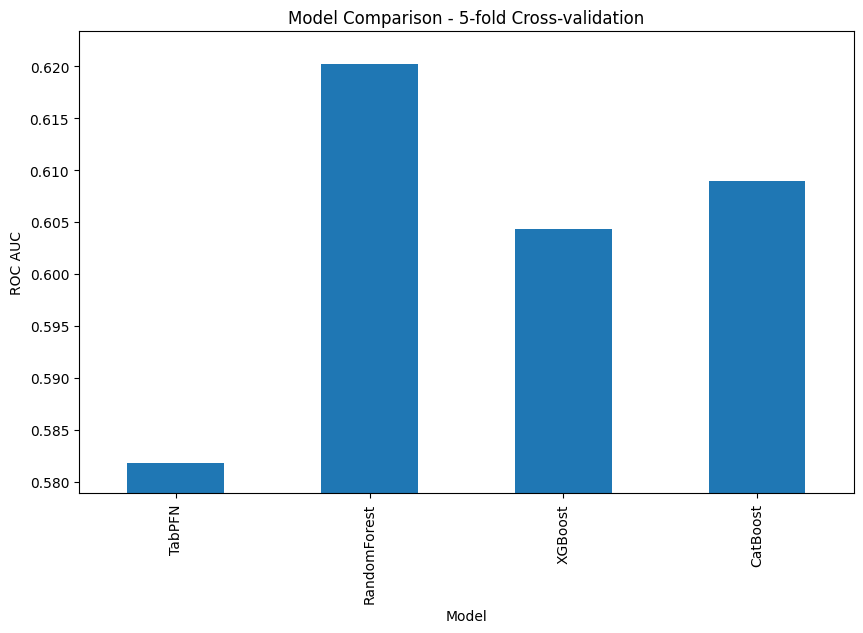

In [7]:
# ==========================================
# Model Comparison using Cross Validation
# ==========================================
# List of models to compare
models = [
    ('TabPFN', TabPFNClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

# Choose scoring - for binary classification, we use 'roc_auc'
scoring = 'roc_auc'
# Calculate 5-fold cross-validation scores on the combined training/validation set
scores = {name: cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs=-1, verbose=1).mean()
          for name, model in models}

print("5-fold Cross-validation ROC AUC scores:")
for name, score in scores.items():
    print(f"{name}: {score:.4f}")

# Plot the results
df_scores = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df_scores.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6), legend=False)
ax.set_ylim(df_scores['ROC AUC'].min()*0.995, min(1.0, df_scores['ROC AUC'].max()*1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')
ax.set_ylabel('ROC AUC')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s finished


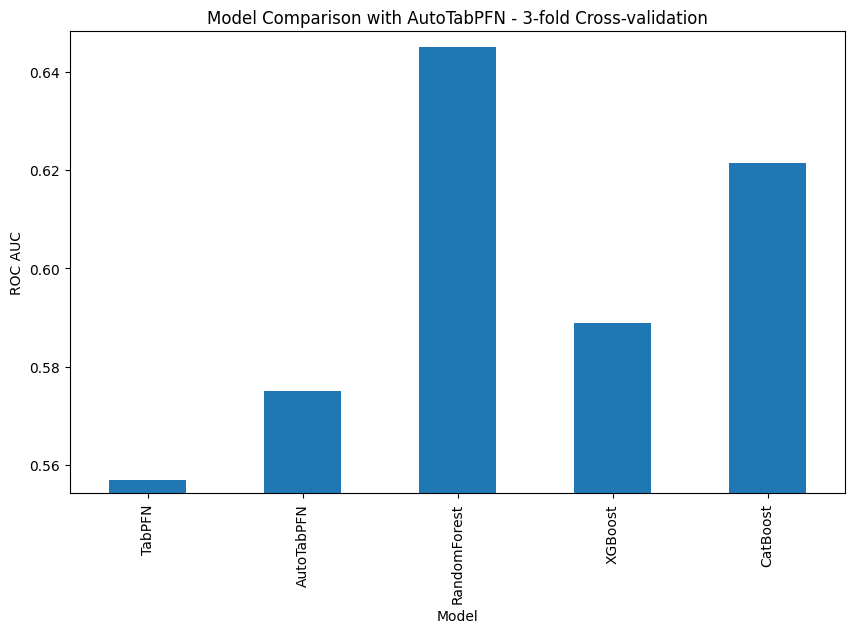

In [9]:
# ==========================================
# Model Comparison Including AutoTabPFNClassifier
# (AutoTabPFN is slower so we run a 3-fold CV)
# ==========================================
models_with_autotab = [
    ('TabPFN', TabPFNClassifier(random_state=42)),
    ('AutoTabPFN', AutoTabPFNClassifier(max_time=30, device="cuda")),  # adjust device if needed
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

scores_auto = {name: cross_val_score(model, X, y, cv=3, scoring=scoring, n_jobs=-1, verbose=1).mean()
               for name, model in models_with_autotab}

df_scores_auto = pd.DataFrame(list(scores_auto.items()), columns=['Model', 'ROC AUC'])
ax = df_scores_auto.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6), legend=False)
ax.set_ylim(df_scores_auto['ROC AUC'].min()*0.995, min(1.0, df_scores_auto['ROC AUC'].max()*1.005))
ax.set_title('Model Comparison with AutoTabPFN - 3-fold Cross-validation')
ax.set_ylabel('ROC AUC')
plt.show()

In [ ]:
# Example Dataset
df = load_breast_cancer(as_frame=True)

X, y = df.data, df.target

# Encode target labels to classes
le = LabelEncoder()
y = le.fit_transform(y)

# Convert all categorical columns to numeric
for col in X.select_dtypes(['category']).columns:
    X[col] = X[col].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Print dataset description
# display(Markdown(df['DESCR']))

display(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)

# Train and evaluate TabPFN
y_pred = TabPFNClassifier(random_state=42).fit(X_train, y_train).predict_proba(X_test)

# Calculate ROC AUC (handles both binary and multiclass)
score = roc_auc_score(y_test, y_pred if len(np.unique(y)) > 2 else y_pred[:, 1])
print(f"TabPFN ROC AUC: {score:.4f}")

In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models = [
    ('TabPFN', TabPFNClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')

In [ ]:
# Adding AutoTabPFN which is significantly slower but gives best results

# Define models
models = [
    ('TabPFN', TabPFNClassifier(random_state=42)),
    ('AutoTabPFN', AutoTabPFNClassifier(max_time=30, device="cuda")), # takes 30 seconds to run so excluded previously
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, X, y, cv=3, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')